In [593]:
def plot_residuals(model):
	fitted = model.fittedvalues
	residuals = model.resid
	standardized_residuals = model.get_influence().resid_studentized_internal

	# Standardized Residuals Plot
	plt.figure(figsize = (8, 6))
	plt.scatter(fitted, standardized_residuals, color = "#1f2db0")
	plt.axhline(0, color = 'red', linestyle = '-')
	plt.axhline(2, color = 'green', linestyle = '--')
	plt.axhline(-2, color = 'green', linestyle = '--')
	plt.xlabel("Predicted y values")
	plt.ylabel("Standardied Residuals")
	plt.title('Standardized Residual Plot')


In [594]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from scipy import stats
import seaborn as sns
import math

# 設定中文字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 設定支援中文的字型
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

In [595]:
# 對 Type 進行前處理，僅留下 Drama, Comedy, Thriller_Suspense, Romaitic_Comedy
filtered_df = filtered_df[filtered_df['genre'].isin(['Drama', 'Comedy', 'Thriller/Suspense', 'Romantic Comedy'])]

In [596]:
# 對 Source 進行前處理

filtered_df['source_category'] = (
    filtered_df['source'].apply(
        lambda x: 'Original Screenplay' if x == 'Original Screenplay' else 'Adapted'
    )
)

In [597]:
# 前處理

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.pow(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.pow(filtered_df["total_box_office"], 1/4)
filtered_df["theatrical_engagements"] = np.pow(filtered_df["theatrical_engagements"], 1/2)
filtered_df['z_score'] = stats.zscore(filtered_df['flattened_total_box_office'])
filtered_df = filtered_df[filtered_df['z_score'].abs() <= 2].copy()


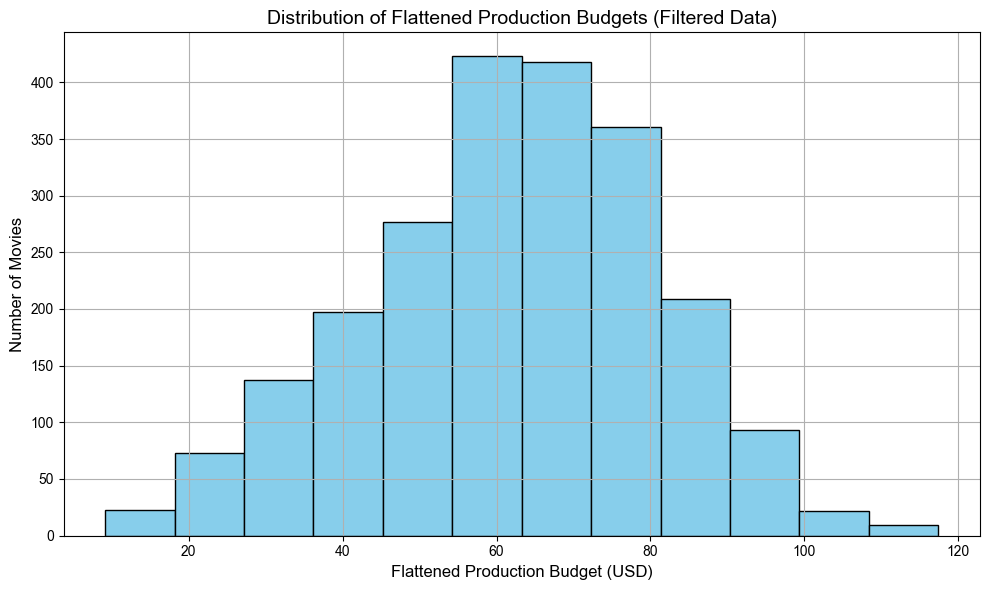

In [598]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['flattened_production_budget'], bins=12, color='skyblue', edgecolor='black')
plt.title('Distribution of Flattened Production Budgets (Filtered Data)', fontsize=14)
plt.xlabel('Flattened Production Budget (USD)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [599]:
# 計算 theatrical_engagements 平均
theatrical_engagements_mean = filtered_df['theatrical_engagements'].mean()
print(theatrical_engagements_mean)

69.46499636467459


In [600]:
# 根據 creative_type 去建立 dummy variable
genre_dummy = pd.get_dummies(filtered_df["genre"].astype(str), prefix="T")
genre_dummy.columns = genre_dummy.columns.str.replace(' ', '_')
genre_dummy.columns = genre_dummy.columns.str.replace('/', '_')
genre_dummy = genre_dummy.drop(columns=["T_Drama"]) 
filtered_df = pd.concat([filtered_df, genre_dummy], axis=1)

source_dummy = pd.get_dummies(filtered_df["source_category"].astype(str), prefix="S")
source_dummy.columns = source_dummy.columns.str.replace(' ', '_')
source_dummy.columns = source_dummy.columns.str.replace('/', '_')
source_dummy.columns = source_dummy.columns.str.replace('-', '_')
source_dummy = source_dummy.drop(columns=["S_Original_Screenplay"]) 
filtered_df = pd.concat([filtered_df, source_dummy], axis=1)

In [601]:
# 去把 budget 和 genre 做交乘
genre_budget_interaction = pd.DataFrame()
for genre in genre_dummy.columns:
    col_name = genre + "_budget_interaction"
    # 把開頭的 T 改成 I
    col_name = col_name.replace('T_', 'I_')
    genre_budget_interaction[col_name] = filtered_df['flattened_production_budget'] * filtered_df[genre]

# 增加 drama 和 budget 的交乘項，但因為沒有 T_Drama，所以用 1 - T_Comedy - T_Thriller_Suspense - T_Romantic_Comedy
genre_budget_interaction['I_Drama_budget_interaction'] = filtered_df['flattened_production_budget'] * (1 - filtered_df['T_Comedy'] - filtered_df['T_Thriller_Suspense'] - filtered_df['T_Romantic_Comedy'])
filtered_df = pd.concat([filtered_df, genre_budget_interaction], axis=1)


In [602]:
# 去把 budget 和 source 做交乘
source_budget_interaction = pd.DataFrame()
for source in source_dummy.columns:
    col_name = source + "_budget_interaction"
    # 把開頭的 S 改成 I
    col_name = col_name.replace('S_', 'I_')
    source_budget_interaction[col_name] = filtered_df['flattened_production_budget'] * filtered_df[source]

source_budget_interaction['I_Original_Screenplay_interaction'] = filtered_df['flattened_production_budget'] * (1 - filtered_df['S_Adapted'])
filtered_df = pd.concat([filtered_df, source_budget_interaction], axis=1)


回歸分析結果摘要：
                                OLS Regression Results                                
Dep. Variable:     flattened_total_box_office   R-squared:                       0.823
Model:                                    OLS   Adj. R-squared:                  0.822
Method:                         Least Squares   F-statistic:                     1727.
Date:                        Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                                22:58:20   Log-Likelihood:                -8928.1
No. Observations:                        2242   AIC:                         1.787e+04
Df Residuals:                            2235   BIC:                         1.791e+04
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
------------

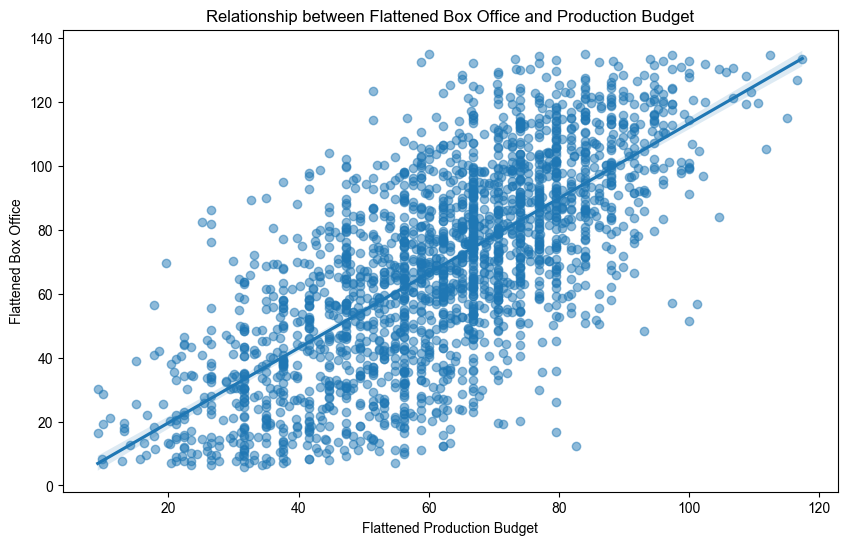

In [603]:
model_formula = "flattened_total_box_office ~ theatrical_engagements"
# model_formula = model_formula + " + " + " + ".join(genre_dummy.columns)
model_formula = model_formula + " + " + " + ".join(source_dummy.columns)
model_formula = model_formula + " + " + " + ".join(genre_budget_interaction.columns)
# model_formula = model_formula + " + " + " + ".join(source_budget_interaction.columns)

# 執行回歸分析
model = sm.ols(formula=model_formula, data=filtered_df).fit()

# 印出回歸結果摘要
print("\n回歸分析結果摘要：")
print(model.summary())

# 繪製散點圖和回歸線
plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_df, x='flattened_production_budget', y='flattened_total_box_office', scatter_kws={'alpha':0.5})
plt.title('Relationship between Flattened Box Office and Production Budget')
plt.xlabel('Flattened Production Budget')
plt.ylabel('Flattened Box Office')
# 畫出來
plt.show()

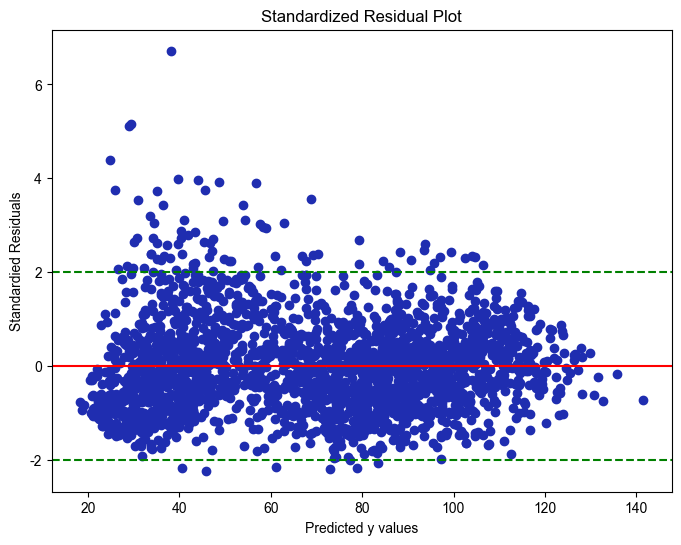

In [604]:
plot_residuals(model)

                                OLS Regression Results                                
Dep. Variable:     flattened_total_box_office   R-squared:                       0.886
Model:                                    OLS   Adj. R-squared:                  0.885
Method:                         Least Squares   F-statistic:                     2712.
Date:                        Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                                22:58:21   Log-Likelihood:                -7947.4
No. Observations:                        2111   AIC:                         1.591e+04
Df Residuals:                            2104   BIC:                         1.595e+04
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

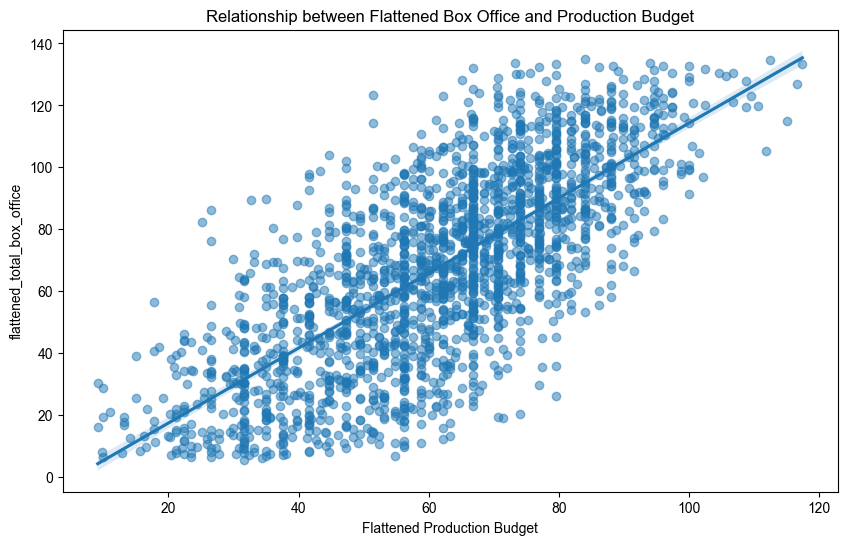

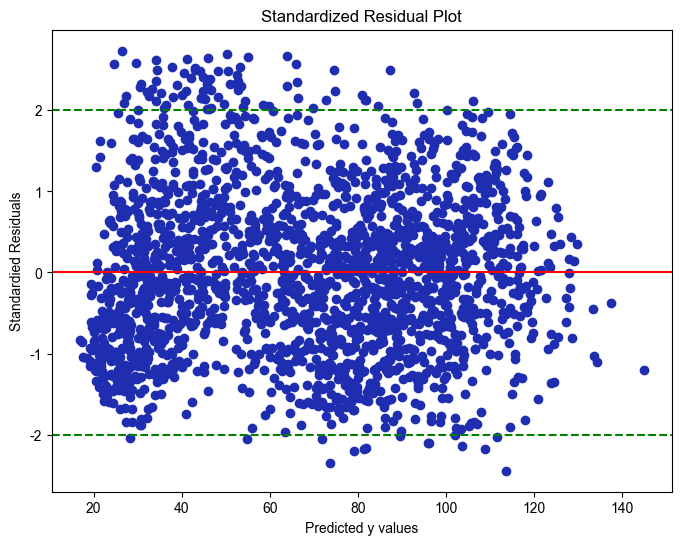

In [605]:
# 去掉殘差與影響值過大的點

# Step 1：取得影響值與殘差
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
standard_resid = influence.resid_studentized_internal

# Step 2：設定門檻
cooks_thresh = 4 / len(filtered_df)
resid_thresh = 2 

# Step 3：留下正常觀測值
mask = (cooks_d < cooks_thresh) & (np.abs(standard_resid) < resid_thresh)
filtered_df = filtered_df[mask].copy()

# Step 4：重新建立模型
model = sm.ols(formula=model_formula, data=filtered_df).fit()
print(model.summary())

# Step 5：繪製殘差圖
plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_df, x='flattened_production_budget', y='flattened_total_box_office', scatter_kws={'alpha':0.5})
plt.title('Relationship between Flattened Box Office and Production Budget')
plt.xlabel('Flattened Production Budget')

plot_residuals(model)   